# Horizontal Partitioning

In [1]:
import math
from os import wait
import os
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom Inserted
from torchjpeg import dct
from PIL import Image
import torchvision.transforms as transforms

# prefix_path_captured_latent_code = prefix_path_captured_latent_code_god2
threshold_list = [0.1, 0.3, 0.35, 0.4, 0.42, 0.45, 0.5, 0.6, 0.7, 1.1, 1.2, 3.5, 5]

# Select based on the difference of downsample input --- BDCT frequency block.
all_private_selection = [[0],
[0, 1],
[0, 1, 2],
[0, 1, 2, 3],
[0, 1, 2, 3, 4],
[0, 1, 2, 3, 4, 5],
[0, 1, 2, 3, 4, 5, 6],
[0, 1, 2, 3, 4, 5, 6, 7],
[0, 1, 2, 3, 4, 5, 6, 7, 8],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]

all_possible_idx = [i for i in range(64)]
selected_privacy_idx = -2

private_idx = all_private_selection[selected_privacy_idx]
public_idx = []

for element in all_possible_idx:
    if element not in private_idx:
        public_idx.append(element)

class DeepAppearanceVAE_Horizontal_Partition(nn.Module):
    def __init__(
        self,
        tex_size=1024,
        mesh_inp_size=21918,
        mode="vae",
        n_latent=128,
        n_cams=38,
        n_blocks=4,
        frequency_threshold=19,
        average_texture_path="/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png",
        prefix_path_captured_latent_code="/home/jianming/work/Privatar_prj/testing_results/horizontal_partition_",
        path_variance_matrix_tensor="/usr/scratch/jianming/Privatar/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_6.0_mutual_bound_1.pth",
        save_latent_code_to_external_device = False,
        apply_gaussian_noise = True,
        res=False,
        non=False,
        bilinear=False,
    ):
        super(DeepAppearanceVAE_Horizontal_Partition, self).__init__()
        
        z_dim = n_latent if mode == "vae" else n_latent * 2
        self.mode = mode
        self.interpolation_ratio = 2
        tex_size = tex_size * self.interpolation_ratio // n_blocks 
        self.block_size = n_blocks
        self.total_frequency_component = self.block_size * self.block_size
        
        self.frequency_threshold = frequency_threshold
        self.private_idx, self.public_idx = self.private_freq_component_thres_based_selection(average_texture_path, frequency_threshold) # ToDo
        
        self.private_total_in_chnl = len(self.private_idx) * 3 # 3 indicates RGB three channels of each frequency broken down
        self.public_total_in_chnl = len(self.public_idx) * 3 # 3 indicates RGB three channels of each frequency broken down
        print(f"public_total_in_chnl={self.public_total_in_chnl}, private_total_in_chnl={self.private_total_in_chnl}")
        self.enc = DeepApperanceEncoderChnlConfig(
            tex_size, mesh_inp_size, n_latent=z_dim, n_in_chnl=self.private_total_in_chnl, res=res
        )
        self.dec = DeepAppearanceDecoderChnlConfig(
            tex_size, mesh_inp_size, z_dim=z_dim, n_in_chnl=self.private_total_in_chnl, res=res, non=non, bilinear=bilinear
        )
        self.enc_outsource = DeepApperanceEncoderNoMeshChnlConfig(
            tex_size, mesh_inp_size, n_latent=z_dim, n_in_chnl=self.public_total_in_chnl, res=res
        )
        self.dec_outsource = DeepAppearanceDecoderNoMeshChnlConfig(
            tex_size, mesh_inp_size, z_dim=z_dim, n_in_chnl=self.public_total_in_chnl, res=res, non=non, bilinear=bilinear
        )
        self.cc = ColorCorrection(n_cams)
        self.iter = 0
        self.iter_outsource = 0
        self.prefix_path_captured_latent_code = prefix_path_captured_latent_code
        self.save_latent_code_to_external_device = save_latent_code_to_external_device
        self.apply_gaussian_noise = apply_gaussian_noise
        directory_being_created = f"{self.prefix_path_captured_latent_code}{self.frequency_threshold}_latent_code"
        print(f"create directory {directory_being_created}")
        if not os.path.exists(f"{self.prefix_path_captured_latent_code}{self.frequency_threshold}_latent_code"):
            os.makedirs(f"{self.prefix_path_captured_latent_code}{self.frequency_threshold}_latent_code")

        self.mean = np.zeros(256)
        if apply_gaussian_noise:
            self.variance_matrix_tensor = torch.load(path_variance_matrix_tensor).cpu()

    def img_reorder(self, x, bs, ch, h, w):
        x = (x + 1) / 2 * 255
        assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
        x = dct.to_ycbcr(x)  # comvert RGB to YCBCR
        x -= 128
        x = x.view(bs * ch, 1, h, w)
        x = F.unfold(x, kernel_size=(self.block_size, self.block_size), dilation=1, padding=0, stride=(self.block_size,self.block_size))
        x = x.transpose(1, 2)
        x = x.view(bs, ch, -1, self.block_size, self.block_size)
        return x
    
    ## Image reordering and testing
    def img_inverse_reroder(self, coverted_img, bs, ch, h, w):
        x = coverted_img.view(bs* ch, -1, self.total_frequency_component)
        x = x.transpose(1, 2)
        x = F.fold(x, output_size=(h, w), kernel_size=(self.block_size,self.block_size), stride=(self.block_size,self.block_size))
        x += 128
        x = x.view(bs, ch, h, w)
        x = dct.to_rgb(x)#.squeeze(0)
        x = (x / 255.0) * 2 - 1
        return x

    def calculate_block_mse(self, downsample_in, freq_block):
        downsample_img = transforms.Resize(size=int(downsample_in.shape[-1]/self.block_size))(downsample_in)
        assert(downsample_img.shape == freq_block[:,:,0,:,:].shape, "downsample input shape does not match the shape of post-BDCT component")
        loss_vector = torch.zeros(freq_block.shape[2])
        for i in range(freq_block.shape[2]):
            # calculate the MSE between each frequency components and given input downsampled images
            loss_vector[i] = F.mse_loss(downsample_img, freq_block[:,:,i,:,:])
        return loss_vector

    def private_freq_component_thres_based_selection(self, img_path, mse_threshold):
        # The original input image comes with it and I disable it to reduce the computation overhead.
        image = Image.open(img_path).convert('RGB')
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        x = transform(image).unsqueeze(0)

        back_input = x
        bs, ch, h, w = x.shape
        block_num = h // self.block_size
        x = self.img_reorder(x, bs, ch, h, w)
        dct_block = dct.block_dct(x) # BDCT
        dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, self.total_frequency_component).permute(0, 1, 4, 2, 3) # into (bs, ch, 16, block_num, block_num)
        loss_vector = self.calculate_block_mse(back_input, dct_block_reorder)
        # Split all component based on the frequency
        private_idx = torch.where(loss_vector > mse_threshold)[0]
        public_idx = []
        all_possible_idx = [i for i in range(self.total_frequency_component)]
        for element in all_possible_idx:
            if element not in private_idx:
                public_idx.append(element)

        return private_idx,  torch.Tensor(public_idx).to(torch.int64)

    def forward(self, avgtex, mesh, view, cams=None):
        # The mesh also needs to be partitioned by two sets of models
        b, n, _ = mesh.shape
        mesh = mesh.view((b, -1))
        # process input avgtex
        # avgtex_interpolate = F.interpolate(avgtex, scale_factor=2, mode='bilinear', align_corners=True)
        # x = avgtex_interpolate
        x = (avgtex + 1) / 2 * 255
        if x.shape[1] != 3:
            print("Wrong input, Channel should equals to 3")
            return
        x = dct.to_ycbcr(x)  # comvert RGB to YCBCR
        x -= 128
        bs, ch, h, w = x.shape
        block_num = h // self.block_size
        x = x.view(bs * ch, 1, h, w)
        x = F.unfold(x, kernel_size=(self.block_size, self.block_size), dilation=1, padding=0, stride=(self.block_size, self.block_size))
        x = x.transpose(1, 2)
        x = x.view(bs, ch, -1, self.block_size, self.block_size)
        dct_block = dct.block_dct(x) # BDCT
        dct_block_reorder = dct_block.view(bs, ch, block_num, block_num, self.total_frequency_component).permute(0, 1, 4, 2, 3) # into (bs, ch, 64, block_num, block_num)
        private_dct_block = dct_block_reorder[:,:,self.private_idx,:,:].view(bs, self.private_total_in_chnl, block_num, block_num)
        public_dct_block = dct_block_reorder[:,:,self.public_idx,:,:].view(bs, self.public_total_in_chnl, block_num, block_num)
        # Inserted Horizontal Parationing logic -- Done

        # mean, logstd = self.enc(avgtex, mesh) # Comment out for enabling horizontal partitioning
        mean, logstd = self.enc(private_dct_block, mesh)
        mean = mean * 0.1
        logstd = logstd * 0.01
        if self.mode == "vae":
            kl = 0.5 * torch.mean(torch.exp(2 * logstd) + mean**2 - 1.0 - 2 * logstd)
            std = torch.exp(logstd)
            eps = torch.randn_like(mean)
            z = mean + std * eps
        else:
            z = torch.cat((mean, logstd), -1)
            kl = torch.tensor(0).to(z.device)
        
        if self.save_latent_code_to_external_device:
            path_captured_latent_code = f"{self.prefix_path_captured_latent_code}{self.frequency_threshold}_latent_code"
            torch.save(logstd, f"{path_captured_latent_code}/logstd_{self.iter}.pth")
            torch.save(mean, f"{path_captured_latent_code}/mean_{self.iter}.pth")
            torch.save(z, f"{path_captured_latent_code}/z_{self.iter}.pth")
            torch.save(kl, f"{path_captured_latent_code}/kl_{self.iter}.pth")
            self.iter = self.iter + 1
        
        pred_tex_private, pred_mesh = self.dec(z, view)
        pred_tex_private = pred_tex_private.view(bs, ch, -1, block_num, block_num)
        
        if self.public_idx != []:
            mean_outsource, logstd_outsource = self.enc_outsource(public_dct_block)
            mean_outsource = mean_outsource * 0.1
            logstd_outsource = logstd_outsource * 0.01
            if self.mode == "vae":
                std_outsource = torch.exp(logstd_outsource)
                eps_outsource = torch.randn_like(mean_outsource)
                z_outsource = mean_outsource + std_outsource * eps_outsource
            else:
                z_outsource = torch.cat((mean_outsource, logstd_outsource), -1)
            
            # Adding model outsource encoder
            if self.apply_gaussian_noise:
                self.variance_matrix_tensor = self.variance_matrix_tensor.cpu()
                samples = torch.from_numpy(np.random.multivariate_normal(self.mean, self.variance_matrix_tensor.detach().numpy(), z_outsource.shape[0]))
                samples = samples.to("cuda:0")
                samples = samples.to(z_outsource.dtype)
                z_outsource = z_outsource + samples

            if self.save_latent_code_to_external_device:
                path_captured_latent_code = f"{self.prefix_path_captured_latent_code}{self.frequency_threshold}_latent_code"
                torch.save(logstd_outsource, f"{path_captured_latent_code}/logstd_outsource_{self.iter_outsource}.pth")
                torch.save(mean_outsource, f"{path_captured_latent_code}/mean_outsource_{self.iter_outsource}.pth")
                torch.save(z_outsource, f"{path_captured_latent_code}/z_outsource_{self.iter_outsource}.pth")
                self.iter_outsource = self.iter_outsource + 1
            
            pred_tex_outsource = self.dec_outsource(z_outsource, view)
            pred_tex_outsource = pred_tex_outsource.view(bs, ch, -1, block_num, block_num)
            # Adding model outsource encoder -- Done

        # Adding block reconstructions
        pred_tex = torch.zeros(bs, ch, self.total_frequency_component, block_num, block_num).to(pred_tex_private.device)

        for i, idx in enumerate(self.private_idx):
            pred_tex[:, :, idx, :, :] = pred_tex_private[:, :, i, :, :]
        for i, idx in enumerate(self.public_idx):
            pred_tex[:, :, idx, :, :] = pred_tex_outsource[:, :, i, :, :]
        
        # Adding block reconstructions -- Done
        # # reorder to revert the layout
        idct_dct_block_reorder = pred_tex.view(bs, ch, self.total_frequency_component, block_num*block_num).permute(0, 1, 3, 2).view(bs, ch, block_num*block_num, self.block_size, self.block_size)

        idct_dct_block = dct.block_idct(idct_dct_block_reorder) #inverse BDCT

        ## Reconstruct the overall original input image
        pred_tex = self.img_inverse_reroder(idct_dct_block, bs, ch, h, w)
        pred_tex = transforms.Resize(size=1024)(pred_tex)
        pred_mesh = pred_mesh.view((b, n, 3))
        if cams is not None:
            pred_tex = self.cc(pred_tex, cams)

        return pred_tex, pred_mesh, kl

    def get_mesh_branch_params(self):
        p = self.enc.get_mesh_branch_params() + self.dec.get_mesh_branch_params()
        return p

    def get_tex_branch_params(self):
        p = self.enc.get_tex_branch_params() + self.dec.get_tex_branch_params()
        return p

    def get_model_params(self):
        params = []
        params += list(self.enc.parameters())
        params += list(self.dec.parameters())
        return params

    def get_cc_params(self):
        return self.cc.parameters()


class WarpFieldDecoder(nn.Module):
    def __init__(self, tex_size=1024, z_dim=128):
        super(WarpFieldDecoder, self).__init__()
        self.mlp = nn.Sequential(
            LinearWN(z_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            LinearWN(256, 1024),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.upsample = nn.Sequential(
            ConvUpsample(256, 128, 128, 2),
            ConvUpsample(128, 128, 64, 2 * (2**2)),
            ConvUpsample(64, 64, 32, 2 * (2**4)),
            ConvUpsample(32, 32, 16, 2 * (2**6)),
            nn.Upsample(size=tex_size, mode='bilinear'),
            nn.Conv2d(16, 2, 3, 1, 1),
        )

        self.apply(lambda x: glorot(x, 0.2))
        glorot(self.upsample[-1], 1.0)

        self.tex_size = tex_size

        xgrid, ygrid = np.meshgrid(np.linspace(-1.0, 1.0, tex_size), np.linspace(-1.0, 1.0, tex_size))
        grid = np.concatenate((xgrid[None, :, :], ygrid[None, :, :]), axis=0)[None, ...].astype(np.float32)
        self.register_buffer("normal_grid", torch.from_numpy(grid))

    def forward(self, z, img):
        b, c, h, w = img.shape

        feat = self.mlp(z).view((-1, 256, 2, 2))
        warp = self.upsample(feat) / self.tex_size
        grid = warp + self.normal_grid
        if grid.shape[2] < img.shape[2]:
            grid = F.interpolate(grid, scale_factor=img.shape[2] / grid.shape[2])
        grid = grid.permute(0, 2, 3, 1).contiguous()

        out = F.grid_sample(img, grid)
        return out, grid


class DeepAppearanceDecoderChnlConfig(nn.Module):
    def __init__(
        self, tex_size, mesh_size, z_dim=128, n_in_chnl=3, res=False, non=False, bilinear=False
    ):
        super(DeepAppearanceDecoderChnlConfig, self).__init__()
        nhidden = z_dim * 4 * 4 # if tex_size == 1024 else z_dim * 2 * 2
        self.texture_decoder = TextureDecoder_Chnl_Config(
            tex_size, z_dim, n_in_chnl, res=res, non=non, bilinear=bilinear
        )
        self.view_fc = LinearWN(3, 8)
        self.z_fc = LinearWN(z_dim, 256)
        self.mesh_fc = LinearWN(256, mesh_size)
        self.texture_fc = LinearWN(256 + 8, nhidden)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.apply(lambda x: glorot(x, 0.2))
        glorot(self.mesh_fc, 1.0)
        glorot(self.texture_decoder.upsample[-1].conv2, 1.0)

    def forward(self, z, v):
        view_code = self.relu(self.view_fc(v))
        z_code = self.relu(self.z_fc(z))
        feat = torch.cat((view_code, z_code), 1)
        texture_code = self.relu(self.texture_fc(feat))
        texture = self.texture_decoder(texture_code)
        mesh = self.mesh_fc(z_code)
        return texture, mesh

    def get_mesh_branch_params(self):
        return list(self.mesh_fc.parameters())

    def get_tex_branch_params(self):
        p = []
        p += list(self.texture_decoder.parameters())
        p += list(self.view_fc.parameters())
        p += list(self.z_fc.parameters())
        p += list(self.texture_fc.parameters())
        return p


class DeepApperanceEncoderNoMeshChnlConfig(nn.Module):
    def __init__(self, inp_size=1024, mesh_inp_size=21918, n_latent=128, n_in_chnl=3, res=False):
        super(DeepApperanceEncoderNoMeshChnlConfig, self).__init__()
        self.n_latent = n_latent
        ntexture_feat = 2048 #if inp_size == 1024 else 512
        self.texture_encoder = TextureEncoder_Chnl_Config(n_in_chnl=n_in_chnl, res=res)
        self.texture_fc = LinearWN(ntexture_feat, 256)
        # self.fc = LinearWN(512, n_latent * 2) # Horizontal Partitioning Modification (Remove Mesh and corresponding input channels from 512 -> 256)
        self.fc = LinearWN(256, n_latent * 2)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.apply(lambda x: glorot(x, 0.2))
        glorot(self.fc, 1.0)

    def forward(self, tex):
        tex_feat = self.relu(self.texture_fc(self.texture_encoder(tex)))
        latent = self.fc(tex_feat)
        return latent[:, : self.n_latent], latent[:, self.n_latent :]

    def get_tex_branch_params(self):
        p = []
        p += list(self.texture_encoder.parameters())
        p += list(self.texture_fc.parameters())
        p += list(self.fc.parameters())
        return p
    

class DeepApperanceEncoderChnlConfig(nn.Module):
    def __init__(self, inp_size=1024, mesh_inp_size=21918, n_latent=128, n_in_chnl=3, res=False):
        super(DeepApperanceEncoderChnlConfig, self).__init__()
        self.n_latent = n_latent
        # ntexture_feat = 2048 if inp_size == 1024 else 512
        ntexture_feat = 2048 #if inp_size == 1024 else 128
        self.texture_encoder = TextureEncoder_Chnl_Config(n_in_chnl=n_in_chnl, res=res)
        self.texture_fc = LinearWN(ntexture_feat, 256)
        self.mesh_fc = LinearWN(mesh_inp_size, 256)
        self.fc = LinearWN(512, n_latent * 2)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.apply(lambda x: glorot(x, 0.2))
        glorot(self.fc, 1.0)

    def forward(self, tex, mesh):
        tex_feat = self.relu(self.texture_fc(self.texture_encoder(tex)))
        mesh_feat = self.relu(self.mesh_fc(mesh))
        feat = torch.cat((tex_feat, mesh_feat), -1)
        latent = self.fc(feat)
        return latent[:, : self.n_latent], latent[:, self.n_latent :]

    def get_mesh_branch_params(self):
        return list(self.mesh_fc.parameters())

    def get_tex_branch_params(self):
        p = []
        p += list(self.texture_encoder.parameters())
        p += list(self.texture_fc.parameters())
        p += list(self.fc.parameters())
        return p


class DeepAppearanceDecoderNoMeshChnlConfig(nn.Module):
    def __init__(
        self, tex_size, mesh_size, z_dim=128, n_in_chnl=3, res=False, non=False, bilinear=False
    ):
        super(DeepAppearanceDecoderNoMeshChnlConfig, self).__init__()
        nhidden = z_dim * 4 * 4 #if tex_size == 1024 else z_dim * 2 * 2
        self.texture_decoder = TextureDecoder_Chnl_Config(
            tex_size, z_dim, n_in_chnl=n_in_chnl, res=res, non=non, bilinear=bilinear
        )
        self.view_fc = LinearWN(3, 8)
        self.z_fc = LinearWN(z_dim, 256)
        self.texture_fc = LinearWN(256 + 8, nhidden)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

        self.apply(lambda x: glorot(x, 0.2))
        glorot(self.texture_decoder.upsample[-1].conv2, 1.0)

    def forward(self, z, v):
        view_code = self.relu(self.view_fc(v))
        z_code = self.relu(self.z_fc(z))
        feat = torch.cat((view_code, z_code), 1)
        texture_code = self.relu(self.texture_fc(feat))
        texture = self.texture_decoder(texture_code)
        return texture

    def get_tex_branch_params(self):
        p = []
        p += list(self.texture_decoder.parameters())
        p += list(self.view_fc.parameters())
        p += list(self.z_fc.parameters())
        p += list(self.texture_fc.parameters())
        return p


class TextureDecoder(nn.Module):
    def __init__(self, tex_size, z_dim, res=False, non=False, bilinear=False):
        super(TextureDecoder, self).__init__()
        base = 2 if tex_size == 512 else 4
        self.z_dim = z_dim

        self.upsample = nn.Sequential(
            ConvUpsample(
                z_dim, z_dim, 64, base, res=res, use_bilinear=bilinear, non=non
            ),
            ConvUpsample(
                64, 64, 32, base * (2**2), res=res, use_bilinear=bilinear, non=non
            ),
            ConvUpsample(
                32, 32, 16, base * (2**4), res=res, use_bilinear=bilinear, non=non
            ),
            ConvUpsample(
                16,
                16,
                3,
                base * (2**6),
                no_activ=True,
                res=res,
                use_bilinear=bilinear,
                non=non,
            ),
        )

    def forward(self, x):
        b, n = x.shape
        h = int(np.sqrt(n / self.z_dim))
        x = x.view((-1, self.z_dim, h, h))
        out = self.upsample(x)
        return out


class TextureEncoder(nn.Module):
    def __init__(self, res=False):
        super(TextureEncoder, self).__init__()
        self.downsample = nn.Sequential(
            ConvDownsample(3, 16, 16, res=res),
            ConvDownsample(16, 32, 32, res=res),
            ConvDownsample(32, 64, 64, res=res),
            ConvDownsample(64, 128, 128, res=res),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        feat = self.downsample(x)
        out = feat.view((b, -1))
        return out


class TextureEncoder_Chnl_Config(nn.Module):
    def __init__(self, n_in_chnl=3, res=False):
        super(TextureEncoder_Chnl_Config, self).__init__()
        self.downsample = nn.Sequential(
            # ConvDownsample(n_in_chnl, 16, 16, res=res),
            # ConvDownsampleSglConv(n_in_chnl, 32, 32, res=res),
            ConvDownsample(n_in_chnl, 32, 32, res=res),
            ConvDownsample(32, 64, 64, res=res),
            ConvDownsample(64, 128, 128, res=res),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        feat = self.downsample(x)
        out = feat.view((b, -1))
        return out

class TextureDecoder_Chnl_Config(nn.Module):
    def __init__(self, tex_size, z_dim, n_in_chnl, res=False, non=False, bilinear=False):
        super(TextureDecoder_Chnl_Config, self).__init__()
        base = 4# if tex_size == 512 else 4
        # base = 2 if tex_size == 512 else 4
        self.z_dim = z_dim
        if bilinear:
            print("user bilinear")
        self.upsample = nn.Sequential(
            ConvUpsample(
                z_dim, z_dim, 64, base, res=res, use_bilinear=bilinear, non=non
            ),
            ConvUpsample(
                64, 64, 32, base * (2**2), res=res, use_bilinear=bilinear, non=non
            ),
            # ConvUpsample(
            #     32, 32, 16, base * (2**4), res=res, use_bilinear=bilinear, non=non
            # ),
            ConvUpsample(
                32,
                32,
                n_in_chnl,
                base * (2**4),
                no_activ=True,
                res=res,
                use_bilinear=bilinear,
                non=non,
            ),
        )

    def forward(self, x):
        b, n = x.shape
        h = int(np.sqrt(n / self.z_dim))
        x = x.view((-1, self.z_dim, h, h))
        out = self.upsample(x)
        return out

class MLP(nn.Module):
    def __init__(self, nin, nhidden, nout):
        self.fc1 = LinearWN(nin, nhidden)
        self.fc2 = LinearWN(nhidden, nout)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        h = self.relu(self.fc1(x))
        out = self.fc2(h)
        return out


class ConvDownsampleSglConv(nn.Module):
    def __init__(self, cin, chidden, cout, res=False):
        super(ConvDownsampleSglConv, self).__init__()
        self.conv1 = Conv2dWN(cin, cout, 4, 2, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        h = self.relu(self.conv1(x))
        return h
    
class ConvDownsample(nn.Module):
    def __init__(self, cin, chidden, cout, res=False):
        super(ConvDownsample, self).__init__()
        self.conv1 = Conv2dWN(cin, chidden, 4, 2, padding=1)
        self.conv2 = Conv2dWN(chidden, cout, 4, 2, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.res = res
        if res:
            self.res1 = Conv2dWN(chidden, chidden, 3, 1, 1)
            self.res2 = Conv2dWN(cout, cout, 3, 1, 1)

    def forward(self, x):
        h = self.relu(self.conv1(x))
        if self.res:
            h = self.relu(self.res1(h) + h)
        h = self.relu(self.conv2(h))
        if self.res:
            h = self.relu(self.res2(h) + h)
        return h


class ConvUpsampleSglConv(nn.Module):
    def __init__(
        self,
        cin,
        chidden,
        cout,
        feature_size,
        no_activ=False,
        res=False,
        use_bilinear=False,
        non=False,
    ):
        super(ConvUpsampleSglConv, self).__init__()
        self.conv2 = DeconvTexelBias(
            chidden, cout, feature_size * 2, use_bilinear=use_bilinear, non=non
        )
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.no_activ = no_activ

    def forward(self, x):
        if self.no_activ:
            h = self.conv2(x)
        else:
            h = self.relu(self.conv2(x))
        return h
    
class ConvUpsample(nn.Module):
    def __init__(
        self,
        cin,
        chidden,
        cout,
        feature_size,
        no_activ=False,
        res=False,
        use_bilinear=False,
        non=False,
    ):
        super(ConvUpsample, self).__init__()
        self.conv1 = DeconvTexelBias(
            cin, chidden, feature_size * 2, use_bilinear=use_bilinear, non=non
        )
        self.conv2 = DeconvTexelBias(
            chidden, cout, feature_size * 4, use_bilinear=use_bilinear, non=non
        )
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.no_activ = no_activ
        self.res = res
        if self.res:
            self.res1 = Conv2dWN(chidden, chidden, 3, 1, 1)
            self.res2 = Conv2dWN(cout, cout, 3, 1, 1)

    def forward(self, x):
        h = self.relu(self.conv1(x))
        if self.res:
            h = self.relu(self.res1(h) + h)
        if self.no_activ:
            h = self.conv2(h)
            if self.res:
                h = self.res2(h) + h
        else:
            h = self.relu(self.conv2(h))
            if self.res:
                h = self.relu(self.res2(h) + h)
        return h


class DeconvTexelBias(nn.Module):
    def __init__(
        self,
        cin,
        cout,
        feature_size,
        ksize=4,
        stride=2,
        padding=1,
        use_bilinear=False,
        non=False,
    ):
        super(DeconvTexelBias, self).__init__()
        if isinstance(feature_size, int):
            feature_size = (feature_size, feature_size)
        self.use_bilinear = use_bilinear
        if use_bilinear:
            self.deconv = Conv2dWN(cin, cout, 3, 1, 1, bias=False)
        else:
            self.deconv = ConvTranspose2dWN(
                cin, cout, ksize, stride, padding, bias=False
            )
        if non:
            self.bias = nn.Parameter(torch.zeros(1, cout, 1, 1))
        else:
            self.bias = nn.Parameter(
                torch.zeros(1, cout, feature_size[0], feature_size[1])
            )

    def forward(self, x):
        if self.use_bilinear:
            x = F.interpolate(x, scale_factor=2)
        out = self.deconv(x) + self.bias
        return out


"""
class ColorCorrection(nn.Module):
    def __init__(self, n_cameras, nc=3):
        super(ColorCorrection, self).__init__()
        weights = torch.zeros(n_cameras, nc, nc, 1, 1)
        for i in range(nc):
            weights[:, i, i] = 1
        self.weights = nn.Parameter(weights)
        self.bias = nn.Parameter(torch.zeros(n_cameras, nc))
        self.anchor = 0
    def forward(self, texture, cam):
        b, c, h, w = texture.shape
        texture = texture.view(1, b*c, h, w)
        weight = self.weights[cam]
        bias = self.bias[cam]
        if self.training:
            weight[cam == self.anchor] = torch.eye(3).view(3, 3, 1, 1).to(texture.device)
            bias[cam == self.anchor] = 0
        weight = weight.view(b*c, 3, 1, 1)
        bias = bias.view(b*c)
        out = F.conv2d(texture, weight, bias, groups=b).view(b, c, h, w)
        return out
"""


class ColorCorrection(nn.Module):
    def __init__(self, n_cameras, nc=3):
        super(ColorCorrection, self).__init__()
        # anchors the 0th camera
        self.weight_anchor = nn.Parameter(torch.ones(1, nc, 1, 1), requires_grad=False)
        self.bias_anchor = nn.Parameter(torch.zeros(1, 3, 1, 1), requires_grad=False)
        self.weight = nn.Parameter(torch.ones(n_cameras - 1, 3, 1, 1))
        self.bias = nn.Parameter(torch.zeros(n_cameras - 1, 3, 1, 1))

    def forward(self, texture, cam):
        weights = torch.cat([self.weight_anchor, self.weight], dim=0)
        biases = torch.cat([self.bias_anchor, self.bias], dim=0)
        w = weights[cam]
        b = biases[cam]
        output = texture * w + b
        return output


def glorot(m, alpha):
    gain = math.sqrt(2.0 / (1.0 + alpha**2))

    if isinstance(m, nn.Conv2d):
        ksize = m.kernel_size[0] * m.kernel_size[1]
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * math.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, nn.ConvTranspose2d):
        ksize = m.kernel_size[0] * m.kernel_size[1] // 4
        n1 = m.in_channels
        n2 = m.out_channels

        std = gain * math.sqrt(2.0 / ((n1 + n2) * ksize))
    elif isinstance(m, nn.Linear):
        n1 = m.in_features
        n2 = m.out_features

        std = gain * math.sqrt(2.0 / (n1 + n2))
    else:
        return

    # m.weight.data.normal_(0, std)
    m.weight.data.uniform_(-std * math.sqrt(3.0), std * math.sqrt(3.0))
    m.bias.data.zero_()

    if isinstance(m, nn.ConvTranspose2d):
        # hardcoded for stride=2 for now
        m.weight.data[:, :, 0::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 0::2] = m.weight.data[:, :, 0::2, 0::2]
        m.weight.data[:, :, 1::2, 1::2] = m.weight.data[:, :, 0::2, 0::2]

    # if isinstance(m, Conv2dWNUB) or isinstance(m, ConvTranspose2dWNUB) or isinstance(m, LinearWN):
    if (
        isinstance(m, Conv2dWNUB)
        or isinstance(m, Conv2dWN)
        or isinstance(m, ConvTranspose2dWN)
        or isinstance(m, ConvTranspose2dWNUB)
        or isinstance(m, LinearWN)
    ):
        norm = np.sqrt(torch.sum(m.weight.data[:] ** 2))
        m.g.data[:] = norm


class LinearWN(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(LinearWN, self).__init__(in_features, out_features, bias)
        self.g = nn.Parameter(torch.ones(out_features))

    def forward(self, input):
        wnorm = torch.sqrt(torch.sum(self.weight**2))
        return F.linear(input, self.weight * self.g[:, None] / wnorm, self.bias)


class Conv2dWNUB(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        height,
        width,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
    ):
        super(Conv2dWNUB, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            False,
        )
        self.g = nn.Parameter(torch.ones(out_channels))
        self.bias = nn.Parameter(torch.zeros(out_channels, height, width))

    def forward(self, x):
        wnorm = torch.sqrt(torch.sum(self.weight**2))
        return (
            F.conv2d(
                x,
                self.weight * self.g[:, None, None, None] / wnorm,
                bias=None,
                stride=self.stride,
                padding=self.padding,
                dilation=self.dilation,
                groups=self.groups,
            )
            + self.bias[None, ...]
        )


class Conv2dWN(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
    ):
        super(Conv2dWN, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            True,
        )
        self.g = nn.Parameter(torch.ones(out_channels))

    def forward(self, x):
        wnorm = torch.sqrt(torch.sum(self.weight**2))
        return F.conv2d(
            x,
            self.weight * self.g[:, None, None, None] / wnorm,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
        )


class ConvTranspose2dWNUB(nn.ConvTranspose2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        height,
        width,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=False,
    ):
        super(ConvTranspose2dWNUB, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            False,
        )
        self.g = nn.Parameter(torch.ones(out_channels))
        self.bias = nn.Parameter(torch.zeros(out_channels, height, width))

    def forward(self, x):
        wnorm = torch.sqrt(torch.sum(self.weight**2))
        return (
            F.conv_transpose2d(
                x,
                self.weight * self.g[None, :, None, None] / wnorm,
                bias=None,
                stride=self.stride,
                padding=self.padding,
                dilation=self.dilation,
                groups=self.groups,
            )
            + self.bias[None, ...]
        )


class ConvTranspose2dWN(nn.ConvTranspose2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
    ):
        super(ConvTranspose2dWN, self).__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            True,
        )
        self.g = nn.Parameter(torch.ones(out_channels))

    def forward(self, x):
        wnorm = torch.sqrt(torch.sum(self.weight**2))
        return F.conv_transpose2d(
            x,
            self.weight * self.g[None, :, None, None] / wnorm,
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
        )

<>:113: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:135: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:113: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:135: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:113: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:135: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_365470/1813210002.py:113: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(x.shape[1] == 3, "Wrong input, Channel should equals to 3")
/tmp/ipykernel_365470/1813210002.py:135: SyntaxWarning: assertion is always true, perhaps rem

In [2]:
import torch
from torchanalyse import profiler, System, Unit

In [3]:
# all locally -- 3456.172032
# completely sourced - 3724.541952
threshold_list = [0.3, 0.305, 0.35, 0.4, 0.42, 0.45, 0.5, 0.6, 0.63, 0.7, 1.035, 1.1, 1.2, 3.5, 5]
# in the horizontal partitioned model, 
encoder_conv_layer_index_list_private_path = [16, 19, 22, 25, 28, 31]
encoder_conv_layer_index_list_outsourced_path = [81, 84, 87, 90, 93, 96]
decoder_conv_layer_index_list_private_path = [60, 63, 66, 69, 72, 75]
decoder_conv_layer_index_list_outsourced_path = [117, 120, 123, 126, 129, 132]

private_path_decode_flops_list = []
private_path_encode_flops_list = []
outsourced_path_encode_flops_list = []
outsourced_path_decode_flops_list = []
op_df_list = []

for threshold in threshold_list:
    model = DeepAppearanceVAE_Horizontal_Partition( 
        tex_size=1024,
        mesh_inp_size=21918,
        mode="vae",
        n_latent=128,
        n_cams=38,
        n_blocks=4,
        frequency_threshold=threshold,
        average_texture_path="/home/jianming/work/multiface/dataset/m--20180227--0000--6795937--GHS/unwrapped_uv_1024/E001_Neutral_Eyes_Open/average/000102.png",
        prefix_path_captured_latent_code="/home/jianming/work/Privatar_prj/testing_results/horizontal_partition_",
        path_variance_matrix_tensor="/home/jianming/work/Privatar_prj/profiled_latent_code/statistics/noise_variance_matrix_horizontal_partition_0_mutual_bound_1.pth",
        save_latent_code_to_external_device = False,
        apply_gaussian_noise = False,
        res=False,
        non=False,
        bilinear=False)

    embed_size = 512
    num_tokens = 30
    unit = Unit()
    system = System(
        unit,
        frequency=940,
        flops=123,
        onchip_mem_bw=900,
        pe_min_density_support=0.0001,
        accelerator_type="structured",
        model_on_chip_mem_implications=False,
        on_chip_mem_size=32,
    )

    # model.private_idx, model.public_idx
    inputs = (
        torch.randn([1, 3, 1024, 1024]),
        torch.randn([1, 7306, 3]),
        torch.randn([1, 3]),
        torch.randn([1]).to(torch.long),
    )

    # macs = profile_macs(model, inputs)
    # print('transformer: {:.4g} G'.format(macs / 1e9))
    op_df = profiler(model, inputs, system, unit)
    display(op_df)
    
    op_df_list.append(op_df)
    
    op_df.to_csv(f"hp_{threshold}.csv")
    print("encoder FLOPS (M)")

    print("Private Path Encoder")
    private_path_encode_flops = []
    for conv_layer_index in encoder_conv_layer_index_list_private_path:
        print(op_df['Flops (MFLOP)'][conv_layer_index])
        private_path_encode_flops.append(op_df['Flops (MFLOP)'][conv_layer_index])

    print("Private Path Decoder")
    private_path_decode_flops = []
    for conv_layer_index in decoder_conv_layer_index_list_private_path:
        print(op_df['Flops (MFLOP)'][conv_layer_index])
        private_path_decode_flops.append(op_df['Flops (MFLOP)'][conv_layer_index])

    print("Outsourced Path Encoder")
    outsourced_path_encode_flops = []
    for conv_layer_index in encoder_conv_layer_index_list_outsourced_path:
        print(op_df['Flops (MFLOP)'][conv_layer_index])
        outsourced_path_encode_flops.append(op_df['Flops (MFLOP)'][conv_layer_index])

    print("Outsourced Path Decoder")
    outsourced_path_decode_flops = []
    for conv_layer_index in decoder_conv_layer_index_list_outsourced_path:
        print(op_df['Flops (MFLOP)'][conv_layer_index])
        outsourced_path_decode_flops.append(op_df['Flops (MFLOP)'][conv_layer_index])

    private_path_decode_flops_list.append(private_path_decode_flops)
    private_path_encode_flops_list.append(private_path_encode_flops)
    outsourced_path_encode_flops_list.append(outsourced_path_encode_flops)
    outsourced_path_decode_flops_list.append(outsourced_path_decode_flops)

public_total_in_chnl=3, private_total_in_chnl=45
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.3_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
754.97472
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
3019.89888
Outsourced Path Encoder
50.331648
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
201.326592
public_total_in_chnl=6, private_total_in_chnl=42
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.305_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
704.643072
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2818.572288
Outsourced Path Encoder
100.663296
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
402.653184
public_total_in_chnl=9, private_total_in_chnl=39
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.35_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
654.311424
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2617.245696
Outsourced Path Encoder
150.994944
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
603.979776
public_total_in_chnl=12, private_total_in_chnl=36
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.4_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
603.979776
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2415.919104
Outsourced Path Encoder
201.326592
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
805.306368
public_total_in_chnl=15, private_total_in_chnl=33
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.42_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
553.648128
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2214.592512
Outsourced Path Encoder
251.65824
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1006.63296
public_total_in_chnl=18, private_total_in_chnl=30
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.45_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
503.31648
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2013.26592
Outsourced Path Encoder
301.989888
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1207.959552
public_total_in_chnl=21, private_total_in_chnl=27
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.5_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
452.984832
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1811.939328
Outsourced Path Encoder
352.321536
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1409.286144
public_total_in_chnl=24, private_total_in_chnl=24
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.6_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
402.653184
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1610.612736
Outsourced Path Encoder
402.653184
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1610.612736
public_total_in_chnl=27, private_total_in_chnl=21
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.63_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
352.321536
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1409.286144
Outsourced Path Encoder
452.984832
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1811.939328
public_total_in_chnl=30, private_total_in_chnl=18
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_0.7_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
301.989888
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1207.959552
Outsourced Path Encoder
503.31648
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2013.26592
public_total_in_chnl=30, private_total_in_chnl=18
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_1.035_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
301.989888
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
1207.959552
Outsourced Path Encoder
503.31648
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2013.26592
public_total_in_chnl=36, private_total_in_chnl=12
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_1.1_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
201.326592
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
805.306368
Outsourced Path Encoder
603.979776
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2415.919104
public_total_in_chnl=39, private_total_in_chnl=9
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_1.2_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
150.994944
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
603.979776
Outsourced Path Encoder
654.311424
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2617.245696
public_total_in_chnl=42, private_total_in_chnl=6
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_3.5_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
100.663296
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
402.653184
Outsourced Path Encoder
704.643072
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
2818.572288
public_total_in_chnl=45, private_total_in_chnl=3
create directory /home/jianming/work/Privatar_prj/testing_results/horizontal_partition_5_latent_code


/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::einsum". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::sub_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::im2col". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::ones". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning: No handlers found: "aten::copy_". Skipped.
/home/jianming/conda/envs/pica37/lib/python3.7/site-packages/torchanalyse-0.0.4-py3.7.egg/torchanalyse/profile.py:39: UserWarning:

,Op Type,Operator A,Operator B,Output,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,C Effcy,Flops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
1,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
2,aten::matmul,"[4, 1]","[1, 4]","[4, 4]",M,0.004878,0.666667,0.0,0.050133,1.0,0.000032,0.000004,0.000004,0.000016,0.000024,0.6,0.000245,0.050133
3,aten::mul,"[4, 1]",1,"[4, 1]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
4,aten::mul,"[1, 4]",1,"[1, 4]",M,0.003252,0.444444,0.0,0.0188,1.0,0.000008,0.000004,0.000001,0.000004,0.000009,0.4,0.000061,0.0188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,aten::mul,1,"[1, 3, 65536, 4, 4]","[1, 3, 65536, 4, 4]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,0.000001,3.145728,3.145728,6.291457,0.45,48.081046,13142.154622
147,aten::mul,1,1,1,M,0.002439,0.333333,0.0,0.006267,1.0,0.000002,0.000001,0.000001,0.000001,0.000003,0.3,0.000015,0.006267
148,aten::mul,"[1, 3, 1024, 1024]",1,"[1, 3, 1024, 1024]",M,0.003659,0.5,0.013981,13142.154622,1.0,6.291456,3.145728,0.000001,3.145728,6.291457,0.45,48.081046,13142.154622
149,aten::upsample_bilinear2d,"[1, 3, 1024, 1024]",0,"[1, 3, 1024, 1024]",M,0.225,2.0,0.013981,13142.152533,1.0,25.165824,3.145728,0.0,3.145728,6.291456,1.8,2956.98432,13142.152533


encoder FLOPS (M)
Private Path Encoder
50.331648
134.217728
67.108864
33.554432
16.777216
8.388608
Private Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
201.326592
Outsourced Path Encoder
754.97472
134.217728
67.108864
33.554432
16.777216
8.388608
Outsourced Path Decoder
33.554432
67.108864
134.217728
268.435456
536.870912
3019.89888


In [4]:
# local computation
print("threshold list")
threshold_list = [0.3, 0.305, 0.35, 0.4, 0.42, 0.45, 0.5, 0.6, 0.63, 0.7, 1.035, 1.1, 1.2, 3.5, 5]

print(threshold_list)

print("Local Computation")
print(private_path_encode_flops_list)
print(private_path_decode_flops_list)

# Outsourced computation
print("Outsourced Computation")
print(outsourced_path_encode_flops_list)
print(outsourced_path_decode_flops_list)

private_path_encode_flops_sum_list = []
private_path_decode_flops_sum_list = []
outsourced_path_encode_flops_sum_list = []
outsourced_path_decode_flops_sum_list = []

for i in range(len(private_path_encode_flops_list)):
    private_path_encode_flops_sum_list.append(np.sum(private_path_encode_flops_list[i]))
    private_path_decode_flops_sum_list.append(np.sum(private_path_decode_flops_list[i]))
    outsourced_path_encode_flops_sum_list.append(np.sum(outsourced_path_encode_flops_list[i]))
    outsourced_path_decode_flops_sum_list.append(np.sum(outsourced_path_decode_flops_list[i]))

threshold list
[0.3, 0.305, 0.35, 0.4, 0.42, 0.45, 0.5, 0.6, 0.63, 0.7, 1.035, 1.1, 1.2, 3.5, 5]
Local Computation
[[754.97472, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [704.643072, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [654.311424, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [603.979776, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [553.648128, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [503.31648, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [452.984832, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [402.653184, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [352.321536, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [301.989888, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [301.989888, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [201.326592, 134.217728, 67.108864, 33.554432, 16.777216, 8.388608], [150.994944, 134.217728, 67.108864, 33.554432, 16.777216, 

In [5]:
print("Local Computation")
print(private_path_encode_flops_sum_list)
print(private_path_decode_flops_sum_list)

print("Outsourced Computation")
print(outsourced_path_encode_flops_sum_list)
print(outsourced_path_decode_flops_sum_list)

private_path_encode_flops_sum_list_array = np.array(private_path_encode_flops_sum_list)
private_path_decode_flops_sum_list_array = np.array(private_path_decode_flops_sum_list)
outsourced_path_encode_flops_sum_list_array = np.array(outsourced_path_encode_flops_sum_list)
outsourced_path_decode_flops_sum_list_array = np.array(outsourced_path_decode_flops_sum_list)

Local Computation
[1015.021568, 964.6899199999999, 914.3582719999999, 864.026624, 813.694976, 763.363328, 713.0316799999999, 662.700032, 612.368384, 562.0367359999999, 562.0367359999999, 461.37343999999996, 411.041792, 360.710144, 310.378496]
[4060.086272, 3858.7596799999997, 3657.4330879999998, 3456.106496, 3254.779904, 3053.4533119999996, 2852.1267199999998, 2650.800128, 2449.4735359999995, 2248.146944, 2248.146944, 1845.4937599999998, 1644.167168, 1442.8405759999998, 1241.5139839999997]
Outsourced Computation
[310.378496, 360.710144, 411.041792, 461.37343999999996, 511.705088, 562.0367359999999, 612.368384, 662.700032, 713.0316799999999, 763.363328, 763.363328, 864.026624, 914.3582719999999, 964.6899199999999, 1015.021568]
[1241.5139839999997, 1442.8405759999998, 1644.167168, 1845.4937599999998, 2046.8203519999997, 2248.146944, 2449.4735359999995, 2650.800128, 2852.1267199999998, 3053.4533119999996, 3053.4533119999996, 3456.106496, 3657.4330879999998, 3858.7596799999997, 4060.086272

In [6]:
private_path_encode_flops_sum_list

[1015.021568,
 964.6899199999999,
 914.3582719999999,
 864.026624,
 813.694976,
 763.363328,
 713.0316799999999,
 662.700032,
 612.368384,
 562.0367359999999,
 562.0367359999999,
 461.37343999999996,
 411.041792,
 360.710144,
 310.378496]

In [7]:
private_path_decode_flops_sum_list_array
array_list = private_path_decode_flops_sum_list_array.tolist()
    
# Inject the element at the specified index
# array_list.insert(0, 3456.172032)
# all locally -- 3456.172032
# completely sourced - 3724.541952

# Convert the list back to a numpy array
private_path_decode_flops_sum_list_array = np.array(array_list)

In [8]:
utilization = 0.6
# available_local_compute = 14 * 1000000 * 0.3
available_local_compute = 1.75 * 1000000
available_outsourced_compute = 1000 * 1000000

print("decoder latency")
local_computation_latency = private_path_decode_flops_sum_list_array / (available_local_compute * utilization)
outsourced_computation_latency = outsourced_path_decode_flops_sum_list_array / (available_outsourced_compute * utilization)
print(f"local decoder compute latency (s) = {local_computation_latency}")
print(f"outsourced decoder compute latency (s) = {outsourced_computation_latency}")

print("Achievable FPS")
print(f"local decoder FPS (frame/s) = {1/local_computation_latency}")
print(f"outsourced decoder FPS (frame/s) = {1/outsourced_computation_latency}")

decoder latency
local decoder compute latency (s) = [0.00386675 0.00367501 0.00348327 0.00329153 0.00309979 0.00290805
 0.00271631 0.00252457 0.00233283 0.00214109 0.00214109 0.00175761
 0.00156587 0.00137413 0.00118239]
outsourced decoder compute latency (s) = [2.06918997e-06 2.40473429e-06 2.74027861e-06 3.07582293e-06
 3.41136725e-06 3.74691157e-06 4.08245589e-06 4.41800021e-06
 4.75354453e-06 5.08908885e-06 5.08908885e-06 5.76017749e-06
 6.09572181e-06 6.43126613e-06 6.76681045e-06]
Achievable FPS
local decoder FPS (frame/s) = [258.61519427 272.10816093 287.08659181 303.81008259 322.60245884
 343.87295063 368.14633538 396.10681655 428.66354119 467.051321
 467.051321   568.9534274  638.62119402 727.73112807 845.74158127]
outsourced decoder FPS (frame/s) = [483280.90358425 415846.35889807 364926.39658402 325116.2442294
 293137.59725602 266886.46914354 244950.59496736 226346.75231161
 210369.33450138 196498.82892986 196498.82892986 173605.76148172
 164049.48103319 155490.37767493 1477

# Communication latency

In [9]:
final_res_index = 132
communication_list = []
for op_df in op_df_list:
    print(np.prod(op_df['Output'][final_res_index])*32/8/1024/1024)
    communication_list.append(np.prod(op_df['Output'][final_res_index])*32/8/1024/1024)
    # print(op_df['Output (MB)'][final_res_index])
    # communication_list.append(op_df['Output (MB)'][final_res_index])

0.75
1.5
2.25
3.0
3.75
4.5
5.25
6.0
6.75
7.5
7.5
9.0
9.75
10.5
11.25


In [10]:
print("communication latency -- FPS")
communication_bandwidth = 20 * (10 ** 3) / 8 # Gbps
communication_latency = np.array(communication_list) / communication_bandwidth
communication_FPS = 1 /communication_latency
print(communication_FPS)
print(communication_latency)


communication latency -- FPS
[3333.33333333 1666.66666667 1111.11111111  833.33333333  666.66666667
  555.55555556  476.19047619  416.66666667  370.37037037  333.33333333
  333.33333333  277.77777778  256.41025641  238.0952381   222.22222222]
[0.0003 0.0006 0.0009 0.0012 0.0015 0.0018 0.0021 0.0024 0.0027 0.003
 0.003  0.0036 0.0039 0.0042 0.0045]


In [11]:
## Original Model -- complete data outsourcing

# decoder FLOPS (M)
# 134.217728
# 134.217728
# 134.217728
# 268.435456
# 536.870912
# 1073.741824
# 2147.483648
# 1610.612736
# [134.217728, 134.217728, 134.217728, 268.435456, 536.870912, 1073.741824, 2147.483648, 1610.612736]
# 6039.7977599999995

In [12]:
print(len(local_computation_latency))
print(len(communication_latency))

15
15


In [13]:
print(local_computation_latency)
print(communication_latency)

[0.00386675 0.00367501 0.00348327 0.00329153 0.00309979 0.00290805
 0.00271631 0.00252457 0.00233283 0.00214109 0.00214109 0.00175761
 0.00156587 0.00137413 0.00118239]
[0.0003 0.0006 0.0009 0.0012 0.0015 0.0018 0.0021 0.0024 0.0027 0.003
 0.003  0.0036 0.0039 0.0042 0.0045]


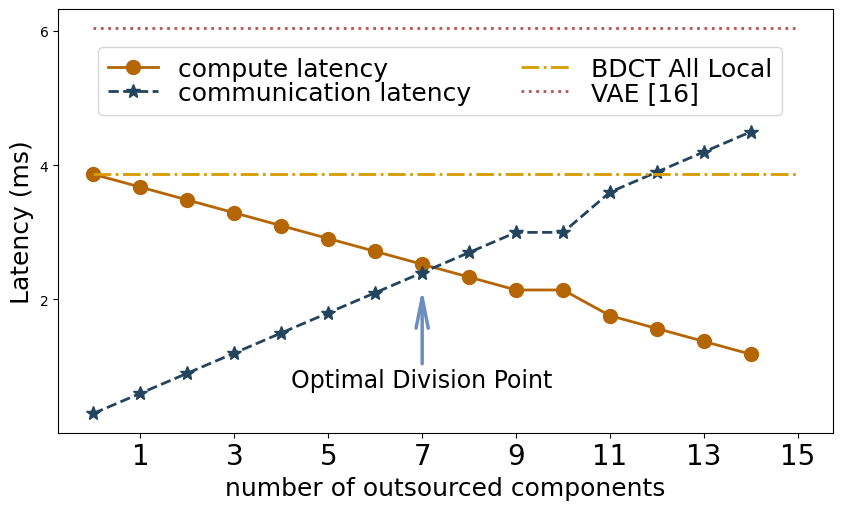

In [14]:
import matplotlib.pyplot as plt
import numpy as np

shape_list = ["o", "*", "X", "p", ">", "d", "s", "H", "<"]
legend_list = ["A", "B", "C", "D", "E", "F", "G", "H"]
color_list = ["#B46504", "#23445D", "#D79B00", "#D6B656", "#B85450", "#9673A6", "#6C8EBF", "#82B366"]

# create data
fig = plt.figure(figsize=[10,5.5])
ax = plt.subplot(111)
# threshold_list = [0.3, 0.305, 0.35, 0.4, 0.42, 0.45, 0.5, 0.6, 0.63, 0.7, 1.035, 1.1, 1.2, 3.5, 5]
threshold_list = [i for i in range(15)]
# x_list = [i for i in range(len(threshold_list))]
ax.plot(threshold_list, local_computation_latency*1000, marker=shape_list[0], markerfacecolor=color_list[0], markersize=10, color=color_list[0], linewidth=2)
ax.plot(threshold_list, communication_latency*1000, marker=shape_list[1], markerfacecolor=color_list[1], markersize=10, color=color_list[1], linewidth=2, linestyle='--')
ax.plot([0, 15], [local_computation_latency[0]*1000, local_computation_latency[0]*1000], markersize=0, color=color_list[2], linewidth=2, linestyle='-.')
ax.plot([0, 15], [6039.7977599999995/1000, 6039.7977599999995/1000], markersize=0, color=color_list[4], linewidth=2, linestyle=':')

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("Latency (ms)", fontsize=SMALL_SIZE)
plt.xlabel("number of outsourced components", fontsize=SMALL_SIZE)
label_xticks = [1, 3, 5, 7, 9, 11, 13, 15]
plt.xticks(label_xticks, [str(label_xtick) for label_xtick in label_xticks], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

# plt.legend(["zcu104", 'Alveo U280'])#, fontsize=SMALL_SIZE)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.legend(["compute latency", "communication latency", "BDCT All Local" , "VAE [16]"], loc='right',  bbox_to_anchor=(0.95, 0.83), fontsize=SMALL_SIZE, ncol=2, labelspacing = 0)#, bbox_to_anchor=(1.3, 0.5), fontsize=SMALL_SIZE)
# plt.legend(plt_handler, ["Computer Energy", "Off-chip Data Access Energy", "On-chip Data Access Energy"], loc='lower center', bbox_to_anchor=(0.5, -0.35), fontsize=MEDIUM_SIZE)
plt.savefig('communi_compute_latency_block_4x4_new.pdf', bbox_inches="tight", transparent=True) 

plt.annotate(text="", xy=(7, 1), xytext=(7, 2.2), color="red", arrowprops=dict(arrowstyle='<-, head_length=1',  linewidth=2.5, color=color_list[6]))
plt.text(7, 0.8, "Optimal Division Point", rotation = 0, fontsize=17, color="k", horizontalalignment='center', verticalalignment='center')
plt.savefig('communi_compute_latency_block_4x4.pdf', bbox_inches="tight", transparent=True) 

plt.show()

In [15]:
overall_latency = []
for i in range(len(communication_latency)):
    if (communication_latency[i] > local_computation_latency[i]):
        overall_latency.append(communication_latency[i])
    else:
        overall_latency.append(local_computation_latency[i])

In [16]:
import math
FPS_local_comp_quest_2_list = [math.floor(1/latency/60) for latency in local_computation_latency]
FPS_local_comp_quest_pro_list = [math.floor(1/latency*8/60) for latency in local_computation_latency]
FPS_local_comm_list = [math.floor(1/latency/60) for latency in communication_latency]
print(FPS_local_comp_quest_2_list)
print(FPS_local_comp_quest_pro_list)
print(FPS_local_comm_list)

[4, 4, 4, 5, 5, 5, 6, 6, 7, 7, 7, 9, 10, 12, 14]
[34, 36, 38, 40, 43, 45, 49, 52, 57, 62, 62, 75, 85, 97, 112]
[55, 27, 18, 13, 11, 9, 7, 6, 6, 5, 5, 4, 4, 3, 3]


In [17]:
latency_label_list = [f"{latency*1000:.02f}" for latency in overall_latency]

In [18]:
print(latency_label_list)

['3.87', '3.68', '3.48', '3.29', '3.10', '2.91', '2.72', '2.52', '2.70', '3.00', '3.00', '3.60', '3.90', '4.20', '4.50']


In [19]:
posterior_successful_rate_list_mutual_info_list = np.array([[0.017557251908396947, 0.017557251908396947, 0.017557251908396947, 0.017557251908396947, 0.017557251908396947, 0.017557251908396947, 0.025114503816793893, 0.025114503816793893, 0.025114503816793893, 0.025114503816793893, 0.03267175572519084, 0.11725190839694656, 0.13221374045801526, 0.18458015267175573, 0.32671755725190843, 1],
 [0.05725190839694656, 0.05725190839694656, 0.05725190839694656, 0.05725190839694656, 0.05725190839694656, 0.05725190839694656, 0.07435114503816793, 0.07435114503816793, 0.07435114503816793, 0.07435114503816793, 0.08152671755725191, 0.1803053435114504, 0.19419847328244275, 0.2511450381679389, 0.4022900763358779, 1],
 [0.28549618320610687, 0.28549618320610687, 0.28549618320610687, 0.28549618320610687, 0.28549618320610687, 0.28549618320610687, 0.330381679389313, 0.330381679389313, 0.330381679389313, 0.330381679389313, 0.3648854961832061, 0.5766412213740457, 0.610381679389313, 0.7004580152671755, 0.9244274809160307, 1],
 [0.48396946564885496, 0.48396946564885496, 0.48396946564885496, 0.48396946564885496, 0.48396946564885496, 0.48396946564885496, 0.5568702290076336, 0.5568702290076336, 0.5568702290076336, 0.5568702290076336, 0.6189312977099237, 0.9099236641221373, 0.9468702290076335, 1, 1, 1]])
posterior_successful_rate_list_mutual_info_list = np.transpose(posterior_successful_rate_list_mutual_info_list)

In [20]:
posterior_successful_rate_list_mutual_info_list.shape

(16, 4)

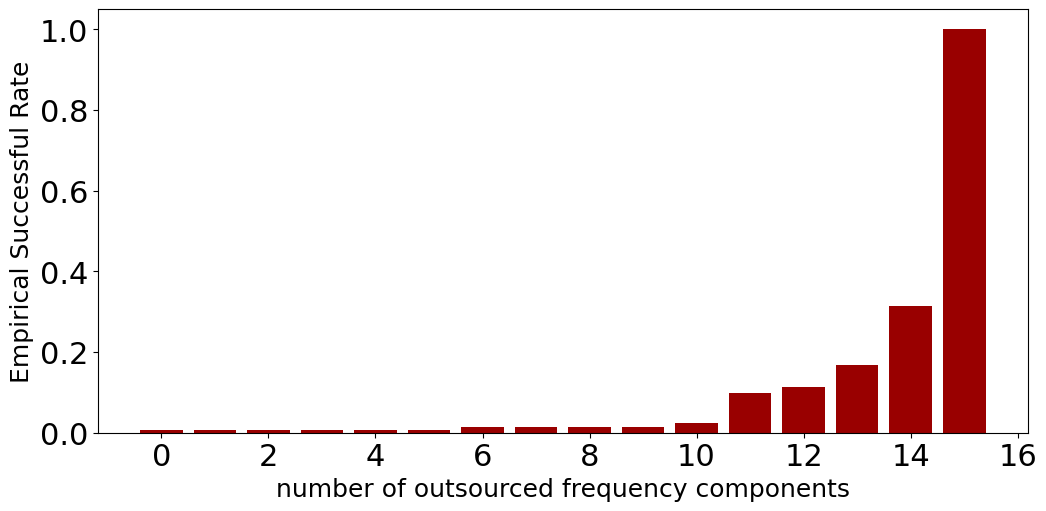

In [22]:
import matplotlib.pyplot as plt

prior_successful_rate_list = [1.0, 0.31297709923664124, 0.16793893129770993, 0.11450381679389313, 0.09923664122137404, 0.022900763358778626, 0.015267175572519083, 0.015267175572519083, 0.015267175572519083, 0.015267175572519083, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542]
# prior_successful_rate_list = prior_successful_rate_list[::-1]

fig = plt.figure(figsize=[12,5.5])
# fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(prior_successful_rate_list))]
prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.bar(x, prior_successful_rate_list, color="#990000")

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("Empirical Successful Rate", fontsize=SMALL_SIZE)
plt.xlabel("number of outsourced frequency components", fontsize=SMALL_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

# plt.legend(["zcu104", 'Alveo U280'])#, fontsize=SMALL_SIZE)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('empirical_successful_rate.pdf', bbox_inches="tight", transparent=True) 

plt.show()

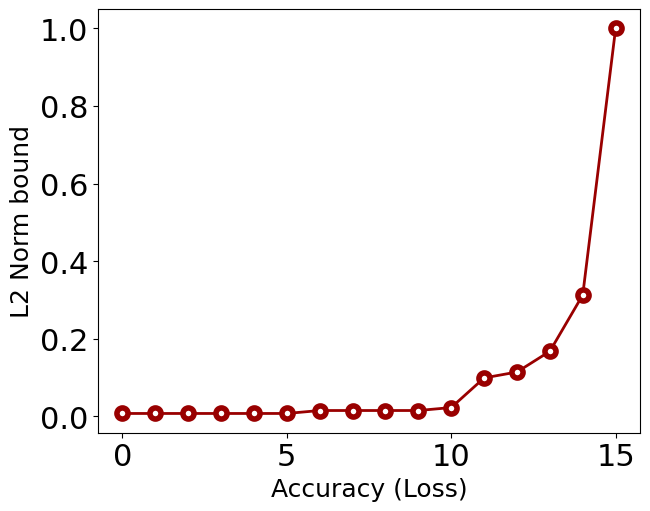

In [23]:
import matplotlib.pyplot as plt

prior_successful_rate_list = [1.0, 0.31297709923664124, 0.16793893129770993, 0.11450381679389313, 0.09923664122137404, 0.022900763358778626, 0.015267175572519083, 0.015267175572519083, 0.015267175572519083, 0.015267175572519083, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542, 0.007633587786259542]
# prior_successful_rate_list = prior_successful_rate_list[::-1]

fig = plt.figure(figsize=[7,5.5])
ax = plt.subplot(111)
x = [i for i in range(len(prior_successful_rate_list))]
prior_successful_rate_list = prior_successful_rate_list[::-1]
plt.plot(x, prior_successful_rate_list, color="#990000", marker=".", markerfacecolor="#ffffff", markersize=16, linewidth=2, markeredgewidth=4)

SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.ylabel("L2 Norm bound", fontsize=SMALL_SIZE)
plt.xlabel("Accuracy (Loss)", fontsize=SMALL_SIZE)
# plt.xticks([i for i in range(int(max(tflop_list)+1))], [str(i) for i in range(int(max(tflop_list)+1))], fontsize=MEDIUM_SIZE)
# plt.title("Scores by Teams in 4 Rounds")

# plt.legend(["zcu104", 'Alveo U280'])#, fontsize=SMALL_SIZE)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize

plt.savefig('L2_norm_under_various_accuracy.pdf', bbox_inches="tight", transparent=True) 

plt.show()